# 🧪 Anomaly Scoring & Heatmaps

In this step, we transform ViT-based features into meaningful **anomaly scores** and **visual heatmaps**.

Using the patch-level embeddings from *test images*, we compare them against the **feature bank** built from `train/good` data. This allows us to detect both image-level anomalies and localize defective regions.

---

### Goals of this notebook:

- Compute **image-level anomaly scores** using:
  - **KNN distance** (via FAISS)
  - Optionally: **Mahalanobis distance**
- Generate **pixel-level heatmaps** by projecting patch distances to spatial grids
- Upsample and visualize heatmaps as overlays on the original images
- Determine an optimal threshold for binary decisions (Youden’s J or best F1)
- Evaluate detection performance using standard metrics (AUROC, PRO, etc.)

---

This scoring approach works **fully unsupervised**, relying only on normal (`train/good`) examples.

By the end of this notebook, you’ll be able to:
- Score all test images
- Visualize and interpret heatmaps
- Quantify anomaly detection performance


## 1️⃣ Load Features & Metadata

In this section, we load the precomputed ViT embeddings and metadata generated during the feature extraction step.

Specifically, we will:
- Load `.npz` feature files (CLS + patch embeddings) for each category
- Load the corresponding `.csv` metadata files
- Merge them into a single DataFrame for easy access and filtering

This unified structure will allow us to:
- Quickly isolate `train/good` features (for scoring)
- Select `test` images for evaluation
- Link embeddings back to image paths for visualization

---

Each entry contains:
- `cls`: global image embedding (ViT CLS token)
- `patches`: local patch embeddings
- `patch_hw`: patch grid shape (e.g., 16×16)
- metadata (path, label, split, etc.)


In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
import pickle

BASE_DIR = Path("..").resolve()

CFG = {
    "dino": {
        "FEAT_DIR": BASE_DIR / "features_dinov2_b14",
        "BANK_DIR": BASE_DIR / "featurebanks" / "dinov2_b14",
        "FEAT_NPZ_TPL": "{cat}_dinov2_vitb14.npz",
        "BANK_NPZ_TPL": "{cat}_bank_dinov2_b14.npz",
    },
    "mae": {
        "FEAT_DIR": BASE_DIR / "features_mae_b16",
        "BANK_DIR": BASE_DIR / "featurebanks" / "mae_b16",
        "FEAT_NPZ_TPL": "{cat}_mae_b16.npz",
        "BANK_NPZ_TPL": "{cat}_bank_mae_b16.npz",
    },
}

def categories_from_feat_dir(feat_dir: Path):
    cats = []
    for p in feat_dir.glob("*_meta.csv"):
        name = p.name
        if name.endswith("_meta.csv"):
            cats.append(name[:-len("_meta.csv")])
    return sorted(set(cats))

def load_feature_data(feat_dir: Path, feat_tpl: str, category: str):
    feat_file = feat_dir / feat_tpl.format(cat=category)
    meta_file = feat_dir / f"{category}_meta.csv"
    data = np.load(feat_file)
    df = pd.read_csv(meta_file)
    return {
        "patches": data["patches"],
        "cls": data.get("cls"),
        "patch_hw": tuple(data["patch_hw"]),
        "meta": df
    }

def load_feature_bank(bank_dir: Path, bank_tpl: str, category: str):
    bank_file = bank_dir / bank_tpl.format(cat=category)
    meta_file = bank_dir / f"{category}_bank_meta.csv"
    data = np.load(bank_file)
    df = pd.read_csv(meta_file)
    return {
        "patches": data["patches"],
        "patch_hw": tuple(data["patch_hw"]),
        "meta": df
    }

def save_dicts_to_disk(backbone: str, features_all: dict, banks: dict, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    for cat in features_all:
        with open(out_dir / f"{cat}_features.pkl", "wb") as f:
            pickle.dump(features_all[cat], f)
        with open(out_dir / f"{cat}_bank.pkl", "wb") as f:
            pickle.dump(banks[cat], f)
        print(f"✅ Saved {cat} ({backbone}) to {out_dir}")

def load_backbone(name: str):
    cfg = CFG[name]
    feat_dir, bank_dir = cfg["FEAT_DIR"], cfg["BANK_DIR"]
    feat_tpl, bank_tpl = cfg["FEAT_NPZ_TPL"], cfg["BANK_NPZ_TPL"]

    categories = categories_from_feat_dir(feat_dir)
    features_all, banks = {}, {}
    for cat in categories:
        features_all[cat] = load_feature_data(feat_dir, feat_tpl, cat)
        banks[cat] = load_feature_bank(bank_dir, bank_tpl, cat)
    return categories, features_all, banks

# Load and save DINO
cats_dino, features_all_dino, banks_dino = load_backbone("dino")
save_dicts_to_disk("dino", features_all_dino, banks_dino, BASE_DIR / "cached_dicts" / "dino")

# Load and save MAE
cats_mae, features_all_mae, banks_mae = load_backbone("mae")
save_dicts_to_disk("mae", features_all_mae, banks_mae, BASE_DIR / "cached_dicts" / "mae")




✅ Saved bottle (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved cable (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved capsule (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved carpet (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved grid (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved hazelnut (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved leather (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved metal_nut (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved pill (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved screw (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved tile (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved toothbrush (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved transistor (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved wood (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved zipper (dino) to C:\Users\Fredi\MVTec\cached_dicts\dino
✅ Saved bottle (mae) to C:\Users\Fr

### Data Structures

After loading, we store the results in two dictionaries.  
This design separates **all extracted embeddings** from the **reference banks**,  
making evaluation, visualization, and anomaly scoring more convenient.

---

- **`features_all`**  
  Contains the **full embeddings** (train + test) for each category.  
  Each entry is a dictionary with:
  - `cls`: global image embeddings `[N, D]`
  - `patches`: patch embeddings `[N, P, D]`
  - `patch_hw`: patch grid dimensions `(H, W)`
  - `meta`: metadata DataFrame (paths, labels, splits)

  → Used when we need to compare across *all images* (e.g., evaluation, visualization).

---

- **`banks`**  
  Contains only the **feature bank**: patch embeddings from `train/good` images.  
  Each entry is a dictionary with:
  - `patches`: patch embeddings `[N, P, D]`
  - `patch_hw`: patch grid dimensions `(H, W)`
  - `meta`: metadata DataFrame for good samples

  → Used as the **reference set** for anomaly scoring: test patches are compared against this bank.


These structures allow us to seamlessly switch between global evaluation (`features_all`) and reference-based scoring (`banks`). In the next step, we leverage them to compute image-level anomaly scores and pixel-level heatmaps.



## 2️⃣ Build Search Index & Image-Level Scoring

After extracting features, the next step is to organize the  
**reference distribution of normal data** and to perform  
**image-level anomaly scoring** based on this reference.  
This combined stage forms the *core* of the anomaly detection pipeline.

Two complementary approaches are implemented:

- **KNN-based feature banks (non-parametric):**  
  Patch embeddings from `train/good` images are stored in a  
  nearest-neighbor index (FAISS, cosine similarity with PCA to 128D).  
  → At inference, each test patch is compared to its closest neighbors  
  in this bank.

- **Mahalanobis distribution (parametric):**  
  For each category, the mean vector (μ) and a shrunk covariance matrix (Σ̂)  
  of `train/good` patches are estimated.  
  → Anomaly scores are then derived from the squared Mahalanobis distance,  
  measuring how well test patches fit into the global distribution.

---

### Image-Level Scoring

For every test image:

1. **Patch-level comparison:**  
   Each patch embedding is compared against the chosen reference  
   (nearest neighbors for KNN, multivariate distance for Mahalanobis).  

2. **Patch scoring:**  
   Each patch receives an anomaly score (distance).  

3. **Image aggregation:**  
   The **Top-K most anomalous patches** are averaged, yielding  
   a single **image-level anomaly score**.  

---

By uniting the **construction of the normal reference** with the  
**aggregation of patch scores into image-level scores**,  
this stage transforms raw features into **directly usable anomaly scores**.  
These scores provide the basis for evaluation, threshold selection,  
and visualization in later steps.




### 🔹2.1 KNN Implementation (with FAISS) 

In our pipeline, the **KNN-based anomaly scoring** is implemented as a 
streaming procedure to stay RAM-safe while handling large feature banks.  
The core logic is encapsulated in [`src/scoring_knn.py`](src/scoring_knn.py).

**Workflow:**
1. **Feature Bank Creation:**  
   All patch embeddings from `train/good` images are stored as `.pkl` files 
   (one `*_features.pkl` for metadata + test/train splits, one `*_bank.pkl` 
   containing the reference patches).

2. **Streaming per Category:**  
   Instead of loading the entire dataset into memory, 
   `score_backbone_streaming()` processes one category at a time.  
   For each category:
   - Load the feature bank (`train/good` patches).  
   - Apply **PCA reduction to 128 dimensions** (from the original 768D).  
     → This lowers memory usage and speeds up FAISS queries, while 
       retaining most discriminative information.  
   - Build a **FAISS index** with **cosine similarity** as metric.  

3. **Patch-Level k-NN Search:**  
   Each test patch is queried against the index.  
   - We use **cosine similarity** instead of L2 distance, because 
     embeddings from pre-trained ViTs (DINO/MAE) are generally 
     normalized and directional information is more robust for 
     anomaly detection.  
   - Anomaly distance = `1 - cosine_similarity`.  
   - For each patch, the **mean distance of its k nearest neighbors** is computed.  

4. **Image-Level Aggregation:**  
   From the patch-level scores, the top-K most anomalous patches are 
   averaged → this yields the **final image-level anomaly score**.  

5. **Output:**  
   Results are appended into a CSV file, one row per test image:  

   | idx | path | category | raw_label | label | image_score |  
   |-----|------|----------|-----------|-------|-------------|  

**Advantages:**
- Memory-efficient (streaming, batch search).  
- PCA (128D) greatly reduces RAM and compute requirements.  
- Cosine similarity aligns better with the embedding geometry of 
  transformers, leading to more stable scoring.  
- GPU-accelerated nearest neighbor queries via FAISS.  

This implementation ensures that anomaly scoring remains **scalable and efficient**, 
while preserving the accuracy benefits of non-parametric k-NN methods.

---




In [1]:
import pandas as pd

# CSV laden, zur Sicherheit Separator explizit angeben
df = pd.read_csv("../scores_knn/scores_STREAM_dino_cosine_k5_top5.csv", sep=",")

# image_score in float konvertieren
df["image_score"] = pd.to_numeric(df["image_score"], errors="coerce")

# Kurzer Check
print(df.dtypes)
print(df["image_score"].head())

# Statistical summary
display(df.describe()[["image_score"]])

# Nur "good" und "defect" berücksichtigen
mean_scores = df[df["label"].isin(["good", "defect"])] \
    .groupby("label")["image_score"].mean()

print("\n🔍 Mean anomaly score per label (cleaned):")
print(mean_scores)

if {"good", "defect"} <= set(mean_scores.index):
    delta = mean_scores["defect"] - mean_scores["good"]
    print(f"\n📈 Difference (defect - good): {delta:.4f}")




idx              int64
path            object
category        object
raw_label       object
label           object
image_score    float64
dtype: object
0    0.357248
1    0.343695
2    0.337819
3    0.422270
4    0.369907
Name: image_score, dtype: float64


,image_score
count,1725.000000
mean,0.177326
std,0.093317
min,0.036037
25%,0.095355
50%,0.164086
75%,0.237263
max,0.641578



🔍 Mean anomaly score per label (cleaned):
label
defect    0.207139
good      0.097017
Name: image_score, dtype: float64

📈 Difference (defect - good): 0.1101


In [40]:
import pandas as pd
from pathlib import Path

# --- Paths ---
p_dino = Path("../scores_knn/scores_STREAM_dino_cosine_k5_top5.csv")
p_mae  = Path("../scores_knn/scores_STREAM_mae_cosine_k5_top5.csv")

# --- Load + clean helper ---
def load_clean_scores(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Ensure numeric (in case it's stored as string)
    if df["image_score"].dtype != "float":
        df["image_score"] = pd.to_numeric(df["image_score"], errors="coerce")
    # Keep only valid labels
    df = df[df["label"].isin(["good", "defect"])].copy()
    # Drop corrupted rows if any
    df = df.dropna(subset=["image_score", "label"])
    return df

df_dino = load_clean_scores(p_dino)
df_mae  = load_clean_scores(p_mae)

# --- Mean per label ---
mean_dino = df_dino.groupby("label")["image_score"].mean()
mean_mae  = df_mae.groupby("label")["image_score"].mean()

# Align index to ensure consistent order
label_order = ["good", "defect"]
mean_dino = mean_dino.reindex(label_order)
mean_mae  = mean_mae.reindex(label_order)

# --- Merge + deltas ---
mean_df = pd.DataFrame({
    "DINO (KNN)": mean_dino,
    "MAE (KNN)":  mean_mae
})
mean_df["Δ (defect - good) DINO"] = mean_dino.loc["defect"] - mean_dino.loc["good"]
mean_df["Δ (defect - good) MAE"]  = mean_mae.loc["defect"]  - mean_mae.loc["good"]

print("🔍 Mean anomaly score per label (KNN):")
display(mean_df)

# Compact delta-only output
delta = pd.Series({
    "DINO (KNN)": mean_dino.loc["defect"] - mean_dino.loc["good"],
    "MAE (KNN)":  mean_mae.loc["defect"]  - mean_mae.loc["good"],
}, name="Δ (defect - good)")
print("\n📈 Score difference (defect - good):")
display(delta)





🔍 Mean anomaly score per label (KNN):


,DINO (KNN),MAE (KNN),Δ (defect - good) DINO,Δ (defect - good) MAE
label,,,,
good,0.097017,0.148898,0.11012,0.034547
defect,0.207137,0.183444,0.11012,0.034547



📈 Score difference (defect - good):


DINO (KNN)    0.110120
MAE (KNN)     0.034547
Name: Δ (defect - good), dtype: float64


#### 📊 Observed Score Distribution (DINO, cosine, PCA=128D, k=5, TopK=5)

*The following results were obtained by running the pipeline in **Google Colab**.*

**Global stats (all test images, N=1,725):**
- count: **1725**
- mean: **0.1773**
- std: **0.0933**
- min / 25% / 50% / 75% / max: **0.0361 / 0.0953 / 0.1641 / 0.2373 / 0.6416**

**By label:**
- good → mean **0.0970**
- defect → mean **0.2071**

**Interpretation:**
- Scores are clearly **higher for defective images** (≈2× on average), which indicates good separability.
- The overall spread (up to ~0.64) shows that strongly anomalous cases stand out clearly.
- A practical starting **threshold** typically falls between **0.12–0.18**  
  (more precisely determined via ROC; e.g., Youden’s J = argmax(tpr − fpr)).

**Implications for downstream evaluation:**
- A **high AUROC** (often ≥0.9) can be expected given this mean gap.  
- For deployment: thresholds should be calibrated per category (e.g., ROC-based or using the 95th percentile of *good* scores).


### 🔹 2.2 Mahalanobis Implementation

In addition to the non-parametric k-NN approach, we also evaluate a **parametric anomaly scoring method** based on the **Mahalanobis distance**.  
Here, the assumption is that the embeddings of *normal* patches (from `train/good`) approximately follow a **multivariate Gaussian distribution**.

**Workflow:**
1. **Fit Distribution:**  
   - Collect all patch embeddings from `train/good`.  
   - Compute the **mean vector** (μ) and a **shrunk covariance matrix** (Σ̂).  
   - Shrinkage (convex combination with identity) ensures stable inversion even when samples are fewer than dimensions or features are correlated.  

2. **O PCA (128D):**  
   To reduce dimensionality and improve numerical stability, PCA is trained on a sample of patches and applied to both train and test embeddings.  

3. **Patch-Level Scoring:**  
   Each test patch is assigned a score equal to its **squared Mahalanobis distance**:  
   $d^2(x) = (x - \mu)^T \hat{\Sigma}^{-1} (x - \mu)$


4. **Image-Level Aggregation:**  
   For each test image, the **Top-K highest patch scores** are averaged, yielding the final **image-level anomaly score**.  

**Advantages:**
- Parametric: explicitly models the distribution of normal data.  
- More compact than storing all patches (no large FAISS index required).  
- Shrinkage + PCA improve stability and reduce overfitting.  

This method provides a **complementary perspective** to k-NN: instead of comparing to individual neighbors, it measures how well a sample fits into the global distribution of normal features.


In [38]:
import gc
import time
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Optional, Tuple
from sklearn.decomposition import PCA

# ----------------- PCA + Mahalanobis Core ----------------- #
def train_pca_on_sample(cache_dir, backbone, categories, pca_dim, sample_cap=200_000, whitening_power=0.0):
    if pca_dim is None:
        return None
    print(f"⏳ PCA: {backbone}, dim={pca_dim}")
    sample_cat = categories[0]
    with open(cache_dir / backbone / f"{sample_cat}_bank.pkl", "rb") as f:
        bank = pickle.load(f)
    sb = bank["patches"].reshape(-1, bank["patches"].shape[-1]).astype(np.float32)
    idx = np.random.choice(len(sb), size=min(sample_cap, len(sb)), replace=False)
    whiten = whitening_power < 0
    pca = PCA(n_components=pca_dim, whiten=whiten)
    pca.fit(sb[idx])
    return pca

def apply_pca_inplace(x: np.ndarray, pca: Optional[PCA]) -> np.ndarray:
    if pca is None:
        return np.ascontiguousarray(x.astype(np.float32, copy=False))
    y = pca.transform(x)
    return np.ascontiguousarray(y.astype(np.float32, copy=False))

def fit_mean_cov_shrunk(X: np.ndarray, shrinkage_alpha: float = 0.1):
    mu = X.mean(axis=0)
    Xc = X - mu
    S = np.cov(Xc, rowvar=False, ddof=1).astype(np.float64)
    trace = np.trace(S) if np.isfinite(np.trace(S)) else np.sum(np.var(X, axis=0))
    lam = trace / max(S.shape[0], 1)
    S_hat = (1.0 - shrinkage_alpha) * S + shrinkage_alpha * lam * np.eye(S.shape[0])
    return mu.astype(np.float32), S_hat.astype(np.float32)

def invert_posdef(S: np.ndarray) -> np.ndarray:
    try:
        L = np.linalg.cholesky(S)
        Linv = np.linalg.solve(L, np.eye(L.shape[0]))
        return (Linv.T @ Linv).astype(np.float32)
    except np.linalg.LinAlgError:
        return np.linalg.pinv(S, rcond=1e-6).astype(np.float32)

def mahalanobis_sq_batch(X: np.ndarray, mu: np.ndarray, S_inv: np.ndarray, batch_size: int = 50_000):
    out = np.empty(X.shape[0], dtype=np.float32)
    for s in range(0, X.shape[0], batch_size):
        e = min(s + batch_size, X.shape[0])
        Xc = X[s:e] - mu
        out[s:e] = np.einsum("ij,jk,ik->i", Xc, S_inv, Xc, optimize=True)
    return out


In [47]:
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import time, gc, pickle
import numpy as np
import pandas as pd

# --- helpers ---
def _infer_hw(P: int) -> Tuple[int, int]:
    r = int(np.sqrt(P))
    return (r, r) if r * r == P else (1, P)

def _save_path_for_npz(patch_out_root: Path, backbone: str, meta_row) -> Path:
    """
    Mirror dataset structure to avoid filename collisions:
    <root>/<backbone>/<category>/<split>/<raw_label>/<filename>.png.npz
    """
    p = Path(str(meta_row["path"]))
    cat   = str(meta_row["category"])
    split = str(meta_row["split"]).lower()
    raw   = str(meta_row["raw_label"])
    fname = p.name  # e.g. "000.png"
    save_dir = patch_out_root / backbone / cat / split / raw
    save_dir.mkdir(parents=True, exist_ok=True)
    return save_dir / f"{fname}.npz"

# --- main ---
def score_all_backbones_mahalanobis_separate(
    cache_dir: Path,
    out_files: Dict[str, Path],             # backbone -> CSV path
    backbones: List[str],                   # e.g. ["dino", "mae"]
    k_top_patches: int = 5,
    pca_dim: Optional[int] = 128,
    pca_whitening_power: float = 0.0,
    shrinkage_alpha: float = 0.1,
    query_batch_size: int = 20_000,
    save_patch_scores: bool = True,
    patch_out_root: Optional[Path] = None,
):
    for backbone in backbones:
        out_file = out_files[backbone]
        out_file.parent.mkdir(parents=True, exist_ok=True)
        wrote_header = False

        b_dir = cache_dir / backbone
        categories = sorted(p.stem.replace("_features", "") for p in b_dir.glob("*_features.pkl"))
        print(f"\n== [{backbone.upper()}] {len(categories)} categories ==")

        # Train PCA on first category (on the patch bank)
        pca = train_pca_on_sample(cache_dir, backbone, categories, pca_dim, whitening_power=pca_whitening_power)

        for cat in categories:
            t0 = time.time()

            # Load features and bank
            with open(b_dir / f"{cat}_features.pkl", "rb") as f: feats = pickle.load(f)
            with open(b_dir / f"{cat}_bank.pkl", "rb") as f: bank = pickle.load(f)

            # Fit distribution (mean & shrunk covariance)
            bank_mat = bank["patches"].reshape(-1, bank["patches"].shape[-1])
            bank_mat = apply_pca_inplace(bank_mat, pca)
            mu, S_hat = fit_mean_cov_shrunk(bank_mat, shrinkage_alpha=shrinkage_alpha)
            S_inv = invert_posdef(S_hat)

            # Extract test patch features
            patches = feats["patches"].astype(np.float32)  # [N, P, D]
            meta = feats["meta"]
            is_test = meta["split"].astype(str).str.lower().eq("test").values
            test_idx = np.where(is_test)[0]
            P, D = patches.shape[1], patches.shape[2]
            X = patches[is_test].reshape(-1, D)
            X = apply_pca_inplace(X, pca)

            # Mahalanobis distances per patch
            patch_scores = mahalanobis_sq_batch(X, mu, S_inv, batch_size=query_batch_size).reshape(-1, P)

            # Top-K aggregation per image
            tk = min(k_top_patches, P)
            order = np.argsort(patch_scores, axis=1)
            topk_idx = order[:, -tk:]
            img_scores = patch_scores[np.arange(len(patch_scores))[:, None], topk_idx].mean(axis=1)

            # Save per-image patch scores (UNIQUE paths)
            if save_patch_scores and patch_out_root is not None:
                H, W = _infer_hw(P)
                for j, i in enumerate(test_idx):
                    save_path = _save_path_for_npz(patch_out_root, backbone, meta.iloc[i])
                    np.savez_compressed(
                        save_path,
                        patch_scores=patch_scores[j],                # (P,)
                        image_score=float(img_scores[j]),           # scalar
                        grid_hw=np.array([H, W], dtype=np.int32),   # e.g., [16, 16]
                        topk_idx=topk_idx[j].astype(np.int32),
                        meta=dict(
                            path=str(meta.iloc[i]["path"]),
                            category=str(meta.iloc[i]["category"]),
                            split=str(meta.iloc[i]["split"]),
                            raw_label=str(meta.iloc[i]["raw_label"]),
                            label=str(meta.iloc[i]["label"]),
                            backbone=str(backbone),
                        ),
                    )

            # Append CSV
            rows = []
            for j, i in enumerate(test_idx):
                rows.append({
                    "idx": int(i),
                    "category": meta.iloc[i]["category"],
                    "path": meta.iloc[i]["path"],
                    "raw_label": meta.iloc[i]["raw_label"],
                    "label": meta.iloc[i]["label"],
                    "image_score": float(img_scores[j]),
                })
            df = pd.DataFrame(rows)
            df.to_csv(out_file, mode="a", header=not wrote_header, index=False)
            wrote_header = True

            # Cleanup
            del feats, bank, bank_mat, mu, S_hat, S_inv, patches, X, patch_scores, img_scores, df
            gc.collect()

            print(f"• {backbone}/{cat}: {len(rows)} imgs in {time.time() - t0:.1f}s")

        print(f"📄 Done → {out_file}")




In [48]:
from pathlib import Path

# Shared configuration
CACHE_DIR = Path("../cached_dicts")
PATCH_OUT_ROOT = Path("../scores_mahalanobis/patch_scores")
PCA_DIM = 128
K_TOP_PATCHES = 5
BATCH_SIZE = 20_000
SHRINKAGE = 0.1
WHITENING = 0.0

# --- Run 1: DINO ---
score_all_backbones_mahalanobis_separate(
    cache_dir=CACHE_DIR,
    out_files={
        "dino": Path("../scores_mahalanobis/scores_mahalanobis_dino.csv")
    },
    backbones=["dino"],
    k_top_patches=K_TOP_PATCHES,
    pca_dim=PCA_DIM,
    pca_whitening_power=WHITENING,
    shrinkage_alpha=SHRINKAGE,
    query_batch_size=BATCH_SIZE,
    save_patch_scores=True,
    patch_out_root=PATCH_OUT_ROOT,
)

# --- Run 2: MAE ---
score_all_backbones_mahalanobis_separate(
    cache_dir=CACHE_DIR,
    out_files={
        "mae": Path("../scores_mahalanobis/scores_mahalanobis_mae.csv")
    },
    backbones=["mae"],
    k_top_patches=K_TOP_PATCHES,
    pca_dim=PCA_DIM,
    pca_whitening_power=WHITENING,
    shrinkage_alpha=SHRINKAGE,
    query_batch_size=BATCH_SIZE,
    save_patch_scores=True,
    patch_out_root=PATCH_OUT_ROOT,
)




== [DINO] 15 categories ==
⏳ PCA: dino, dim=128
• dino/bottle: 83 imgs in 0.4s
• dino/cable: 150 imgs in 0.6s
• dino/capsule: 132 imgs in 0.5s
• dino/carpet: 117 imgs in 0.6s
• dino/grid: 78 imgs in 0.5s
• dino/hazelnut: 110 imgs in 0.7s
• dino/leather: 124 imgs in 0.6s
• dino/metal_nut: 115 imgs in 0.5s
• dino/pill: 167 imgs in 0.7s
• dino/screw: 160 imgs in 0.7s
• dino/tile: 117 imgs in 0.5s
• dino/toothbrush: 42 imgs in 0.2s
• dino/transistor: 100 imgs in 0.5s
• dino/wood: 79 imgs in 0.5s
• dino/zipper: 151 imgs in 0.6s
📄 Done → ..\scores_mahalanobis\scores_mahalanobis_dino.csv

== [MAE] 15 categories ==
⏳ PCA: mae, dim=128
• mae/bottle: 83 imgs in 0.4s
• mae/cable: 150 imgs in 0.6s
• mae/capsule: 132 imgs in 0.6s
• mae/carpet: 117 imgs in 0.6s
• mae/grid: 78 imgs in 0.5s
• mae/hazelnut: 110 imgs in 0.7s
• mae/leather: 124 imgs in 0.6s
• mae/metal_nut: 115 imgs in 0.5s
• mae/pill: 167 imgs in 0.7s
• mae/screw: 160 imgs in 0.7s
• mae/tile: 117 imgs in 0.5s
• mae/toothbrush: 42 imgs 

In [33]:
import pandas as pd
from pathlib import Path

# --- Paths ---
p_dino = Path("../scores_mahalanobis/scores_mahalanobis_dino.csv")
p_mae  = Path("../scores_mahalanobis/scores_mahalanobis_mae.csv")

def analyze_scores(path: Path, model_name: str):
    print(f"\n=== {model_name} :: Mahalanobis scoring ===")
    
    # Load CSV
    df = pd.read_csv(path, sep=",")
    
    # Ensure numeric
    df["image_score"] = pd.to_numeric(df["image_score"], errors="coerce")
    
    # Quick type / head check
    print(df.dtypes)
    print(df["image_score"].head())
    
    # Statistical summary
    display(df.describe()[["image_score"]])
    
    # Keep only good/defect
    mean_scores = (
        df[df["label"].isin(["good", "defect"])]
        .groupby("label")["image_score"]
        .mean()
    )
    
    print("\n🔍 Mean anomaly score per label (cleaned):")
    print(mean_scores)
    
    # Difference defect - good
    if {"good", "defect"} <= set(mean_scores.index):
        delta = mean_scores["defect"] - mean_scores["good"]
        print(f"\n📈 Difference (defect - good): {delta:.4f}")

# --- Run for both backbones ---
analyze_scores(p_dino, "DINO")
analyze_scores(p_mae,  "MAE")



=== DINO :: Mahalanobis scoring ===
idx             object
category        object
path            object
raw_label       object
label           object
image_score    float64
dtype: object
0    320.992706
1    297.331390
2    308.148987
3    315.113953
4    330.248535
Name: image_score, dtype: float64


,image_score
count,6921.000000
mean,418.711800
std,214.234865
min,157.835602
25%,260.797150
50%,338.385559
75%,508.260559
max,1473.911621



🔍 Mean anomaly score per label (cleaned):
label
defect    482.330091
good      245.735683
Name: image_score, dtype: float64

📈 Difference (defect - good): 236.5944

=== MAE :: Mahalanobis scoring ===
idx             object
category        object
path            object
raw_label       object
label           object
image_score    float64
dtype: object
0    212.623291
1    195.192902
2    240.066895
3    199.570724
4    217.294144
Name: image_score, dtype: float64


,image_score
count,5175.000000
mean,310.277570
std,294.352502
min,67.903641
25%,169.548019
50%,231.408295
75%,353.813065
max,3728.071045



🔍 Mean anomaly score per label (cleaned):
label
defect    338.13229
good      235.24280
Name: image_score, dtype: float64

📈 Difference (defect - good): 102.8895


In [46]:
import pandas as pd
from pathlib import Path

# --- Paths ---
p_dino = Path("../scores_mahalanobis/scores_mahalanobis_dino.csv")
p_mae  = Path("../scores_mahalanobis/scores_mahalanobis_mae.csv")

# --- Load + clean helper ---
def load_clean_scores(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Ensure numeric (in case it's stored as string)
    if df["image_score"].dtype != "float":
        df["image_score"] = pd.to_numeric(df["image_score"], errors="coerce")
    # Keep only valid labels
    df = df[df["label"].isin(["good", "defect"])].copy()
    # Drop corrupted rows if any
    df = df.dropna(subset=["image_score", "label"])
    return df

df_dino = load_clean_scores(p_dino)
df_mae  = load_clean_scores(p_mae)

# --- Mean per label ---
mean_dino = df_dino.groupby("label")["image_score"].mean()
mean_mae  = df_mae.groupby("label")["image_score"].mean()

# Align index to ensure consistent order
label_order = ["good", "defect"]
mean_dino = mean_dino.reindex(label_order)
mean_mae  = mean_mae.reindex(label_order)

# --- Merge + deltas ---
mean_df = pd.DataFrame({
    "DINO (Mahalanobis)": mean_dino,
    "MAE (Mahalanobis)":  mean_mae
})
mean_df["Δ (defect - good) DINO"] = mean_dino.loc["defect"] - mean_dino.loc["good"]
mean_df["Δ (defect - good) MAE"]  = mean_mae.loc["defect"]  - mean_mae.loc["good"]

print("🔍 Mean anomaly score per label (Mahalanobis):")
display(mean_df)

# Compact delta-only output
delta = pd.Series({
    "DINO (Mahalanobis)": mean_dino.loc["defect"] - mean_dino.loc["good"],
    "MAE (Mahalanobis)":  mean_mae.loc["defect"]  - mean_mae.loc["good"],
}, name="Δ (defect - good)")
print("\n📈 Score difference (defect - good):")
display(delta)




🔍 Mean anomaly score per label (Mahalanobis):


,DINO (Mahalanobis),MAE (Mahalanobis),Δ (defect - good) DINO,Δ (defect - good) MAE
label,,,,
good,246.608054,235.242807,233.318809,102.890157
defect,479.926864,338.132964,233.318809,102.890157



📈 Score difference (defect - good):


DINO (Mahalanobis)    233.318809
MAE (Mahalanobis)     102.890157
Name: Δ (defect - good), dtype: float64

label                  defect        good       delta
model category                                       
DINO  carpet       835.504764  233.736024  601.768740
      tile         774.050724  248.848613  525.202110
      grid         794.353416  285.629668  508.723748
      leather      693.182693  264.367688  428.815005
      zipper       476.425873  224.632967  251.792906
      wood         523.786757  281.094628  242.692129
      hazelnut     447.757313  235.060581  212.696732
      metal_nut    380.468981  203.140633  177.328348
      pill         387.196596  258.893767  128.302829
      toothbrush   346.776514  245.286944  101.489570
      cable        321.438807  231.593279   89.845528
      capsule      331.993054  243.674856   88.318198
      bottle       334.117874  254.821966   79.295909
      transistor   332.336306  258.782110   73.554196
      screw        297.208728  249.166105   48.042623
MAE   leather     1147.355790  347.486264  799.869526
      wood         450.121112  179.281781  270.839331
      hazelnut     621.370982  351.445428  269.925554
      tile         255.495732  125.756230  129.739502
      carpet       299.212726  200.725566   98.487160
      toothbrush   303.165556  248.806416   54.359141
      grid         152.324370  100.790546   51.533824
      zipper       138.305153  107.048915   31.256238
      screw        428.719054  401.844325   26.874728
      bottle       199.026097  184.116492   14.909604
      metal_nut    311.706043  296.826484   14.879559
      capsule      199.303386  188.117868   11.185519
      transistor   280.462728  270.286442   10.176286
      pill         157.810242  149.976996    7.833246
      cable        209.187629  204.226122    4.961507

### 🔎 Summary of Results (KNN vs. Mahalanobis)

We evaluated anomaly scores using two backbones (**DINO** and **MAE**) with two distance metrics (**KNN** and **Mahalanobis**).  
The table below shows the mean anomaly score for *good* and *defect* samples, as well as the difference between them (defect – good).  
A larger difference indicates a clearer separation between normal and anomalous samples.

| Metric         | Model | Good (↓ better) | Defect (↑ better) | Δ (defect – good) |
|----------------|-------|-----------------|-------------------|-------------------|
| **KNN**        | DINO  | 0.097           | 0.207             | **0.110** |
|                | MAE   | 0.149           | 0.183             | 0.035 |
| **Mahalanobis**| DINO  | 246.6           | 479.9             | **233.3** |
|                | MAE   | 235.2           | 338.1             | 102.9 |

#### Key observations
- **DINO consistently outperforms MAE** in both metrics, achieving a larger separation (Δ) between good and defect.
- **Mahalanobis yields higher absolute score ranges** than KNN, but the relative separation is what matters — DINO again provides the clearest gap.
- **MAE shows weaker separation**, especially with KNN, which may limit its discriminative power for anomaly detection.

#### Next step: Heatmaps
While global scores provide evidence that DINO (especially with Mahalanobis) is more discriminative, they do not reveal *where* anomalies occur.  
The next step is **pixel-level heatmap generation**:
- Map patch-level distances back to the image grid (e.g., 16×16 feature map).
- Upsample to the original resolution.
- Overlay as heatmaps to visualize **localized defects**.

This will allow a **qualitative evaluation** and demonstrate whether the quantitative advantage of DINO also translates into clearer anomaly localization.



## 4️⃣ Heatmap Generation (Pixel-Level)

While image-level anomaly scores provide a single value per image (indicating whether it is normal or defective), they do not reveal **where** the anomaly occurs.  
To gain deeper insights, we generate **pixel-level heatmaps** that localize potential defects within the image.

The core idea is straightforward:

1. **Patch-level distances**: Each test image is split into patches (e.g., 16×16 grid for a 256×256 image). Distances between these patches and the normal feature distribution serve as local anomaly scores.
2. **Interpolation**: The patch-level grid is upsampled (e.g., bilinear interpolation) to match the original image resolution.
3. **Visualization**: The resulting map can be rendered as a heatmap or overlayed on the original image, clearly highlighting defective regions.

This step transforms anomaly detection from a **binary decision** into an interpretable, **explainable localization task** — essential for real-world quality inspection scenarios.


### 🔍 CSV vs. NPZ Consistency Check

Before we start generating heatmaps, we first ensure that the  
**CSV outputs** (image-level scores) and the saved **NPZ files**  
(per-image patch scores) are consistent.

**What this script does:**
1. Load the CSV file containing image-level anomaly scores.
2. For each category, count:
   - `CSV rows`: number of test images in the CSV.
   - `NPZ files`: number of `.npz` patch score files stored under  
     `patch_scores/<backbone>/<category>/<split>/<raw_label>/`.
3. Print a summary table per category and total, with a checkmark ✓ if counts match,  
   or ✗ if they differ.

**Why this matters before heatmaps:**
- Each heatmap is generated from its corresponding `.npz` patch score file.  
- If CSV rows and NPZ files don’t match, some images will be missing heatmaps.  
- This check ensures that all test images are ready for visualization.


In [10]:
import pandas as pd
from pathlib import Path
from IPython.display import display, HTML

# ====== Paths ======
CSV_MAH_DINO   = Path("../scores_mahalanobis/scores_mahalanobis_dino.csv")
PATCH_MAH_DINO = Path("../scores_mahalanobis/patch_scores/dino")
CSV_KNN_DINO   = Path("../scores_knn/scores_STREAM_dino_cosine_k5_top5.csv")
PATCH_KNN_DINO = Path("../scores_knn/patch_scores/dino")

CSV_MAH_MAE   = Path("../scores_mahalanobis/scores_mahalanobis_mae.csv")
PATCH_MAH_MAE = Path("../scores_mahalanobis/patch_scores/mae")
CSV_KNN_MAE   = Path("../scores_knn/scores_STREAM_mae_cosine_k5_top5.csv")
PATCH_KNN_MAE = Path("../scores_knn/patch_scores/mae")


def make_summary(csv_file: Path, patch_root: Path) -> pd.DataFrame:
    """Build a summary DataFrame: per category CSV vs NPZ counts + match ✅/❌."""
    if not csv_file.exists() or not patch_root.exists():
        return pd.DataFrame()

    df = pd.read_csv(csv_file)
    summary = []
    for cat, group in df.groupby("category"):
        csv_count = len(group)
        npz_count = len(list((patch_root / cat).rglob("*.npz")))
        ok = "✅" if csv_count == npz_count else "❌"
        summary.append((cat, csv_count, npz_count, ok))

    total_csv = len(df)
    total_npz = len(list(patch_root.rglob("*.npz")))
    summary.append(("TOTAL", total_csv, total_npz, "✅" if total_csv == total_npz else "❌"))

    return pd.DataFrame(summary, columns=["Category", "CSV rows", "NPZ files", "Match"])


def render_side_by_side(df1: pd.DataFrame, df2: pd.DataFrame, title1: str, title2: str):
    """Render two DataFrames side by side with proper width using flexbox."""
    style = """
    <style>
    .flex-container {
        display: flex;
        justify-content: space-between;
        gap: 20px;
    }
    .flex-item {
        flex: 1;
        max-width: 49%;
    }
    .flex-item table {
        width: 100%;
    }
    th {
        text-align: center;
    }
    </style>
    """
    html = f"""
    {style}
    <div class="flex-container">
        <div class="flex-item">
            <h3 style="text-align:center">{title1}</h3>
            {df1.to_html(index=False, escape=False)}
        </div>
        <div class="flex-item">
            <h3 style="text-align:center">{title2}</h3>
            {df2.to_html(index=False, escape=False)}
        </div>
    </div>
    """
    display(HTML(html))


# ====== Build summaries ======
dino_mahal = make_summary(CSV_MAH_DINO, PATCH_MAH_DINO)
dino_knn   = make_summary(CSV_KNN_DINO, PATCH_KNN_DINO)

mae_mahal  = make_summary(CSV_MAH_MAE, PATCH_MAH_MAE)
mae_knn    = make_summary(CSV_KNN_MAE, PATCH_KNN_MAE)

# ====== Show results ======
render_side_by_side(dino_mahal, dino_knn, "Mahalanobis · DINO", "KNN · DINO")
render_side_by_side(mae_mahal, mae_knn, "Mahalanobis · MAE", "KNN · MAE")




Category,CSV rows,NPZ files,Match
bottle,83,83,✅
cable,150,150,✅
capsule,132,132,✅
carpet,117,117,✅
grid,78,78,✅
hazelnut,110,110,✅
leather,124,124,✅
metal_nut,115,115,✅
pill,167,167,✅
screw,160,160,✅


Category,CSV rows,NPZ files,Match
bottle,83,83,✅
cable,150,150,✅
capsule,132,132,✅
carpet,117,117,✅
grid,78,78,✅
hazelnut,110,110,✅
leather,124,124,✅
metal_nut,115,115,✅
pill,167,167,✅
screw,160,160,✅


### 🔍 Consistency Check Passed

All data is consistent --- every test image listed in the CSV files has
a corresponding `.npz` file with patch scores.\
This means we can safely proceed with heatmap generation.

------------------------------------------------------------------------

### 🎨 Heatmap Generation Logic

For each test image, the process is:

1.  **Load the `.npz` file**, which contains:

    -   `patch_scores`: anomaly score per patch (e.g., 256 values for a
        16×16 grid).\
    -   `grid_hw`: the patch grid shape (e.g., \[16,16\]).\
    -   `meta`: metadata such as path, label, and category.

2.  **Reshape** the patch scores into a 2D grid (`grid_h × grid_w`).

3.  **Upscale** this patch grid to the original image resolution using
    interpolation.

4.  **Overlay the heatmap** on the original image:

    -   Normalize patch scores to \[0,1\].\
    -   Apply a colormap (`jet`, `magma`, ...).\
    -   Blend the heatmap with the original image using transparency.

5.  **Visualize or save**:

    -   Display inline in the notebook for inspection.\
    -   Optionally, save heatmap images for later analysis.

In [43]:
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# ---------------- Config ---------------- #
BACKBONE      = "dino"  # "dino" or "mae"
PATCH_ROOT    = Path(f"../scores_knn/patch_scores/{BACKBONE}")  # adjust if you want mahalanobis instead
MVTEC_ROOT    = Path("../data/mvtec")                           # your dataset root
PER_CATEGORY  = 3                                               # up to N images per category
RANDOM_SEED   = 42

random.seed(RANDOM_SEED)


# ---------------- I/O helpers ---------------- #
def load_npz(npz_path: Path):
    d = np.load(npz_path, allow_pickle=True)
    patch_scores = d["patch_scores"]
    grid_h, grid_w = [int(x) for x in d["grid_hw"]]
    meta = d["meta"].item()
    img_score = float(d["image_score"])
    return patch_scores, (grid_h, grid_w), meta, img_score

def img_path_from_meta(meta: dict, mvtec_root: Path) -> Path:
    fname = Path(meta["path"]).name
    cat   = str(meta["category"])
    split = str(meta["split"]).lower()
    raw   = str(meta["raw_label"])
    return (mvtec_root / cat / split / raw / fname).resolve()

def mask_path_from_meta(meta: dict, mvtec_root: Path) -> Path:
    fname = Path(meta["path"]).name
    cat   = str(meta["category"])
    raw   = str(meta["raw_label"])
    return (mvtec_root / cat / "ground_truth" / raw / fname.replace(".png", "_mask.png")).resolve()


# ---------------- Normalization (GLOBAL per category) ---------------- #
def compute_global_minmax_for_category(cat_dir: Path) -> tuple[float, float]:
    """
    Scan all .npz under this category (recursively) and compute global min/max of patch_scores.
    This gives a shared color scale across all images of the same category.
    """
    npz_files = list(cat_dir.rglob("*.npz"))
    if not npz_files:
        return (0.0, 1.0)
    mins, maxs = [], []
    for f in npz_files:
        try:
            d = np.load(f, allow_pickle=True)
            ps = d["patch_scores"]
            mins.append(float(ps.min()))
            maxs.append(float(ps.max()))
        except Exception:
            # skip broken files
            continue
    if not mins:
        return (0.0, 1.0)
    gmin, gmax = float(min(mins)), float(max(maxs))
    if not np.isfinite(gmin) or not np.isfinite(gmax) or gmax <= gmin:
        # safe fallback
        return (0.0, 1.0)
    return (gmin, gmax)


# ---------------- Heatmap utils ---------------- #
def make_heatmap(patch_scores: np.ndarray,
                 grid_hw: tuple[int,int],
                 H: int, W: int,
                 norm_min: float | None = None,
                 norm_max: float | None = None) -> np.ndarray:
    """
    Build heatmap from patch scores and resize to (W,H).
    If norm_min/max are provided, apply global (category-wide) normalization.
    Otherwise falls back to per-image min-max (not recommended).
    """
    gh, gw = grid_hw
    patch_map = patch_scores.reshape(gh, gw)
    heat = cv2.resize(patch_map, (W, H), interpolation=cv2.INTER_CUBIC).astype(np.float32)

    # Global normalization (preferred): use provided norm range
    if norm_min is not None and norm_max is not None and np.isfinite(norm_min) and np.isfinite(norm_max) and norm_max > norm_min:
        heat = (heat - norm_min) / (norm_max - norm_min)
    else:
        # Fallback: per-image min-max (can make good images look overly red)
        mn, mx = float(heat.min()), float(heat.max())
        if mx > mn:
            heat = (heat - mn) / (mx - mn)
        else:
            heat[:] = 0.0

    # clamp to [0,1] to avoid tiny numeric drifts
    np.clip(heat, 0.0, 1.0, out=heat)
    return heat


def _input_size_from_backbone(backbone: str) -> tuple[int, int]:
    b = str(backbone).strip().lower()
    if b == "dino":
        return (224, 224)
    if b == "mae":
        return (256, 256)
    return (224, 224)


def plot_triplet_to_file(
    npz_file: Path,
    out_path: Path,
    mvtec_root: Path,
    backbone: str = BACKBONE,
    alpha: float = 0.5,
    cmap: str = "jet",
    # NEW: pass global normalization (min,max) here
    norm_min: float | None = None,
    norm_max: float | None = None,
):
    # --- load data ---
    patch_scores, grid_hw, meta, img_score = load_npz(npz_file)

    # --- resolve original image ---
    ipath = img_path_from_meta(meta, mvtec_root)
    img = np.array(Image.open(ipath).convert("RGB"))

    # --- target (feature) input size aligned to backbone ---
    H_in, W_in = _input_size_from_backbone(backbone)

    # --- resize original image to feature input size ---
    img_aligned = cv2.resize(img, (W_in, H_in), interpolation=cv2.INTER_AREA)

    # --- heatmap from patches -> same (aligned) size with GLOBAL category normalization ---
    heat = make_heatmap(patch_scores, grid_hw, H_in, W_in, norm_min=norm_min, norm_max=norm_max)

    # --- ground-truth mask (defects only) ---
    mpath = mask_path_from_meta(meta, mvtec_root)
    if mpath.exists():
        mask_raw = np.array(Image.open(mpath).convert("L"))
        mask = cv2.resize(mask_raw, (W_in, H_in), interpolation=cv2.INTER_NEAREST)
    else:
        mask = np.zeros((H_in, W_in), dtype=np.uint8)

    # --- figure ---
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(img_aligned)
    axs[0].set_title("Original (aligned)")
    axs[0].axis("off")

    axs[1].imshow(img_aligned)
    axs[1].imshow(heat, cmap=cmap, alpha=alpha)
    axs[1].set_title(f"Heatmap ({backbone}, {H_in}×{W_in})")
    axs[1].axis("off")

    axs[2].imshow(img_aligned)
    axs[2].imshow(mask, cmap="Reds", alpha=0.5)
    axs[2].set_title("Ground Truth (aligned)")
    axs[2].axis("off")

    plt.suptitle(f"{meta['category']} | {meta['raw_label']} | score={img_score:.4f}", y=0.98)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close(fig)


def sample_npz_for_category_exact(cat_dir: Path, per_category: int = 3) -> list[Path]:
    assert per_category >= 1
    need_good = 1
    need_def  = per_category - need_good

    candidates = list(cat_dir.glob("test/*/*.npz"))
    if not candidates:
        return []

    # group by raw_label
    by_raw = {}
    for p in candidates:
        raw = p.parent.name
        by_raw.setdefault(raw, []).append(p)

    good_list = by_raw.pop("good", [])
    for lst in by_raw.values():
        random.shuffle(lst)
    random.shuffle(good_list)

    picked = []

    # pick exactly 1 good if possible
    if good_list:
        picked.append(good_list.pop())
    else:
        print(f"[WARN] No 'good' in {cat_dir.name} – will fill with defects only.")

    # fill with diverse defects
    defect_types = list(by_raw.keys())
    random.shuffle(defect_types)
    def_pool = {k: by_raw[k][:] for k in defect_types}
    def_picked = 0
    idx = 0
    while def_picked < need_def and defect_types:
        k = defect_types[idx % len(defect_types)]
        if def_pool[k]:
            picked.append(def_pool[k].pop()); def_picked += 1
        defect_types = [d for d in defect_types if def_pool[d]]
        idx += 1

    # top-up ONLY with remaining defects (no extra goods)
    if len(picked) < per_category:
        leftovers = [p for lst in def_pool.values() for p in lst]
        random.shuffle(leftovers)
        for p in leftovers:
            if len(picked) >= per_category: break
            picked.append(p)

    # final trim
    picked = picked[:per_category]

    # report
    n_good = sum(1 for p in picked if p.parent.name == "good")
    n_def  = len(picked) - n_good
    if n_good != 1:
        print(f"[WARN] {cat_dir.name}: selected good={n_good} (expected 1)")
    if n_def < need_def:
        print(f"[WARN] {cat_dir.name}: not enough defects (got {n_def}, need {need_def})")

    return picked


In [44]:
from pathlib import Path

# -------- Choose what to run --------
METHOD   = "knn"          # "knn" or "mahalanobis"
BACKBONE = "dino"         # "dino" or "mae"

# -------- Derived paths --------
BASE_SCORES = {
    "knn": Path("../scores_knn"),
    "mahalanobis": Path("../scores_mahalanobis"),
}

PATCH_ROOT = BASE_SCORES[METHOD] / "patch_scores" / BACKBONE
OUT_DIR    = Path(f"../triplets_{METHOD}/{BACKBONE}")  # e.g. ../triplets_knn/dino
OUT_DIR.mkdir(parents=True, exist_ok=True)

# (Optional) dataset root stays as before
MVTEC_ROOT = Path("../data/mvtec")


In [47]:
COMBOS = [
    ("knn", "dino"),
    ("knn", "mae"),
    ("mahalanobis", "dino"),
    ("mahalanobis", "mae"),
]

def assert_mvtec_category_exists(cat: str, mvtec_root: Path):
    cat_root = mvtec_root / cat
    if not cat_root.exists():
        raise FileNotFoundError(
            f"MVTec category folder not found under MVTEC_ROOT:\n"
            f"  Expected: {cat_root}\n"
            f"Hint: Point MVTEC_ROOT to the directory that contains categories like 'bottle', 'cable', ...\n"
            f"Example: MVTEC_ROOT = Path('D:/Datasets/mvtec_anomaly_detection')"
        )

for METHOD, BACKBONE in COMBOS:
    PATCH_ROOT = BASE_SCORES[METHOD] / "patch_scores" / BACKBONE
    OUT_DIR    = Path(f"../triplets_{METHOD}/{BACKBONE}")
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    print(f"\n=== {METHOD.upper()} · {BACKBONE.upper()} ===")

    # Build category list from PATCH_ROOT, skipping hidden dirs and checkpoints
    if not PATCH_ROOT.exists():
        print(f"[WARN] Patch root does not exist: {PATCH_ROOT}")
        continue

    all_cats = sorted([
        d.name
        for d in PATCH_ROOT.iterdir()
        if d.is_dir() and not d.name.startswith(".") and d.name != ".ipynb_checkpoints"
    ])
    print(f"Found categories under {PATCH_ROOT}: {all_cats}")

    for cat in all_cats:
        # Ensure the category exists under the dataset root (for original images / GT)
        assert_mvtec_category_exists(cat, MVTEC_ROOT)

        cat_dir = PATCH_ROOT / cat
        npz_list = sample_npz_for_category_exact(cat_dir, per_category=3)
        if not npz_list:
            print(f"[WARN] No NPZ found for '{cat}' under {cat_dir/'test/*/*.npz'}")
            continue

        n_good = sum(1 for p in npz_list if p.parent.name == "good")
        n_def  = len(npz_list) - n_good
        print(f"{cat}: picked {len(npz_list)} → good={n_good}, defect={n_def}")

        for npz_path in npz_list:
            raw_label = npz_path.parent.name
            fname = npz_path.stem  # e.g. "000.png"
            out_path = OUT_DIR / cat / f"{raw_label}__{fname.replace('.png','')}.png"
            try:
                plot_triplet_to_file(npz_path, out_path, MVTEC_ROOT, backbone=BACKBONE)
            except FileNotFoundError as e:
                print(f"[MISS] {e}")
            except Exception as e:
                print(f"[ERR ] {npz_path}: {e}")




=== KNN · DINO ===
Found categories under ..\scores_knn\patch_scores\dino: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
bottle: picked 3 → good=1, defect=2
cable: picked 3 → good=1, defect=2
capsule: picked 3 → good=1, defect=2
carpet: picked 3 → good=1, defect=2
grid: picked 3 → good=1, defect=2
hazelnut: picked 3 → good=1, defect=2
leather: picked 3 → good=1, defect=2
metal_nut: picked 3 → good=1, defect=2
pill: picked 3 → good=1, defect=2
screw: picked 3 → good=1, defect=2
tile: picked 3 → good=1, defect=2
toothbrush: picked 3 → good=1, defect=2
transistor: picked 3 → good=1, defect=2
wood: picked 3 → good=1, defect=2
zipper: picked 3 → good=1, defect=2

=== KNN · MAE ===
Found categories under ..\scores_knn\patch_scores\mae: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zi

### Triplet Generation (Original • Heatmap • Ground Truth)

The previous code automatically generated **triplets** for every MVTec category,  
covering all four combinations of methods and backbones:

- **KNN + DINO**  
- **KNN + MAE**  
- **Mahalanobis + DINO**  
- **Mahalanobis + MAE**

For each category, the procedure sampled **3 test images** (1 "good" + 2 "defects").  
Each sample was saved as a triplet image showing (from left to right):

1. **Original image (aligned to model input size)**  
2. **Predicted anomaly heatmap** (based on patch scores)  
3. **Ground truth mask** (if available, otherwise empty)  

The triplets were written to disk in structured folders:

```
triplets_knn/dino/<category>/
triplets_knn/mae/<category>/
triplets_mahalanobis/dino/<category>/
triplets_mahalanobis/mae/<category>/
```

This ensures we can later **browse or directly compare** results across methods  
without recomputing the heatmaps.


Sample: bottle/broken_large/000.png

KNN · DINO → ..\triplets_knn\dino\bottle\broken_large__000.png


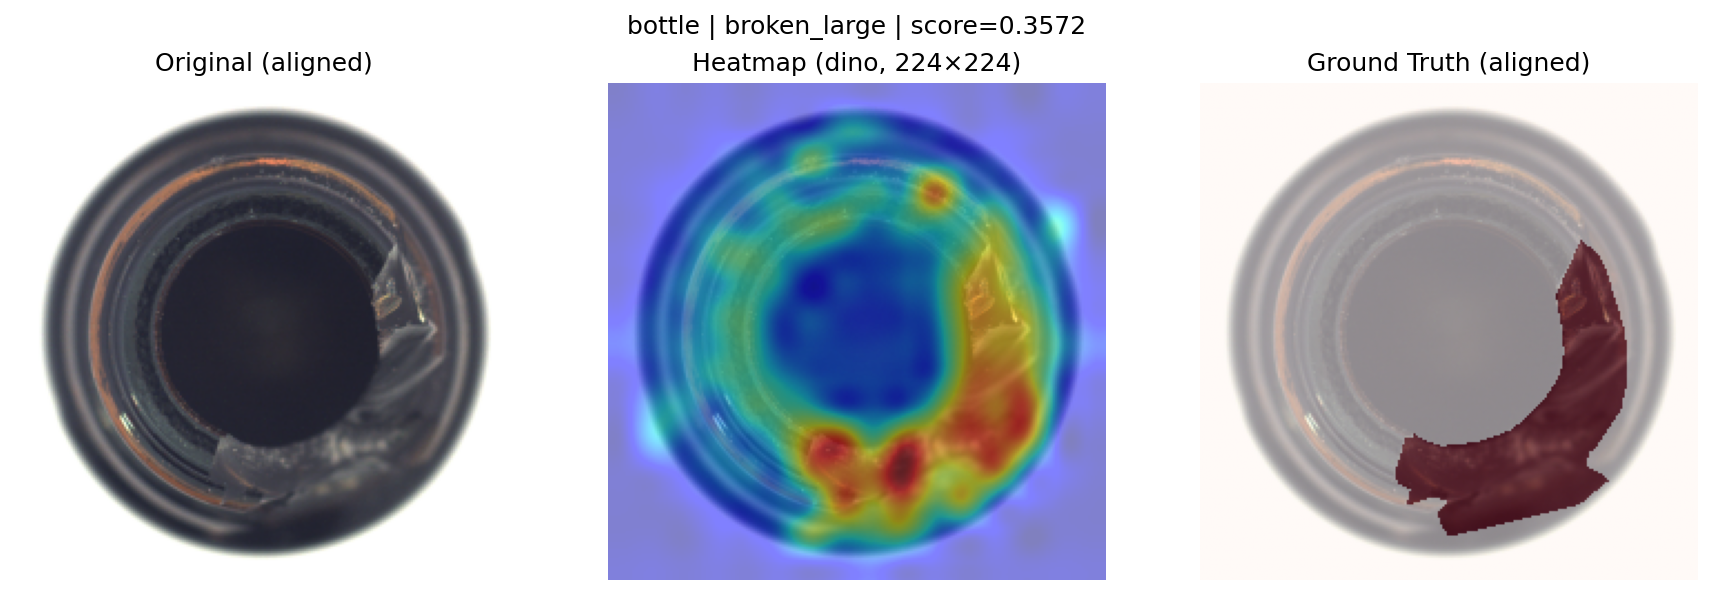

KNN · MAE → ..\triplets_knn\mae\bottle\broken_large__000.png


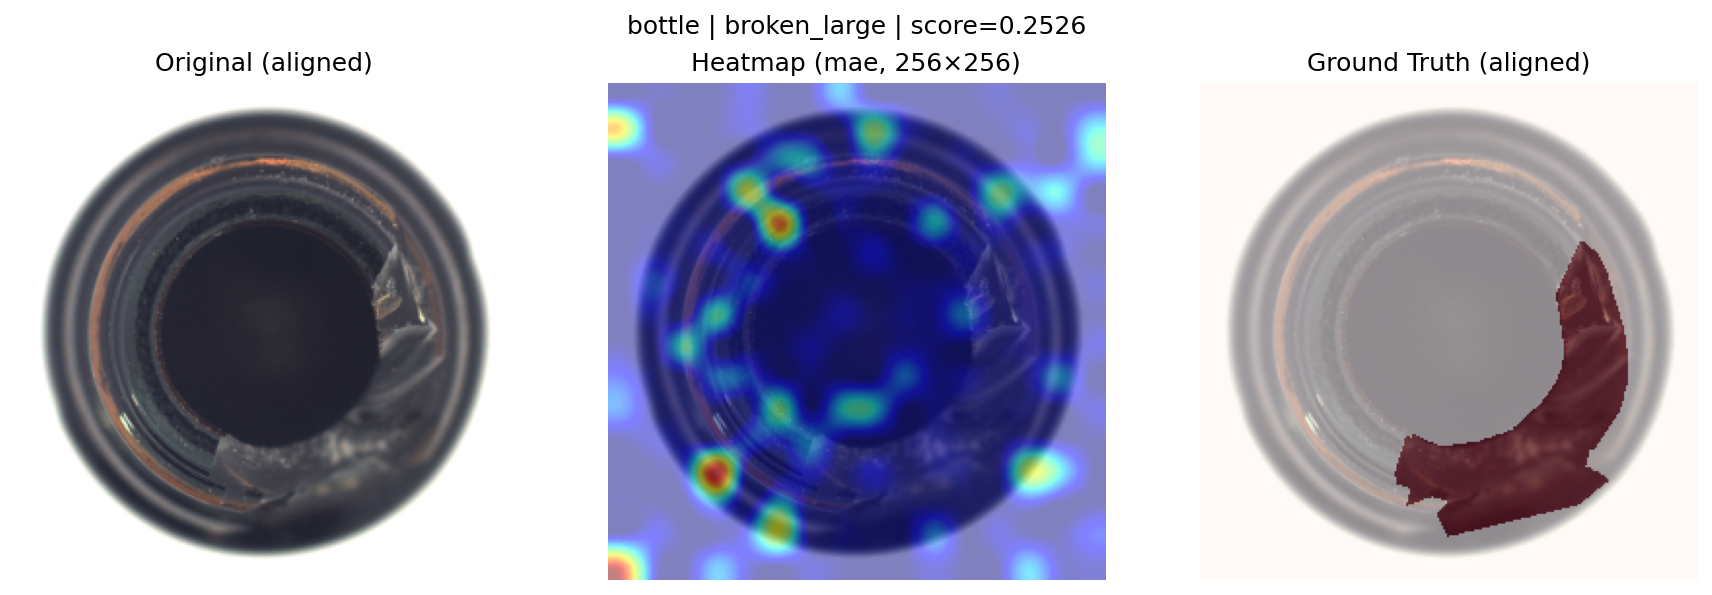

MAHALANOBIS · DINO → ..\triplets_mahalanobis\dino\bottle\broken_large__000.png


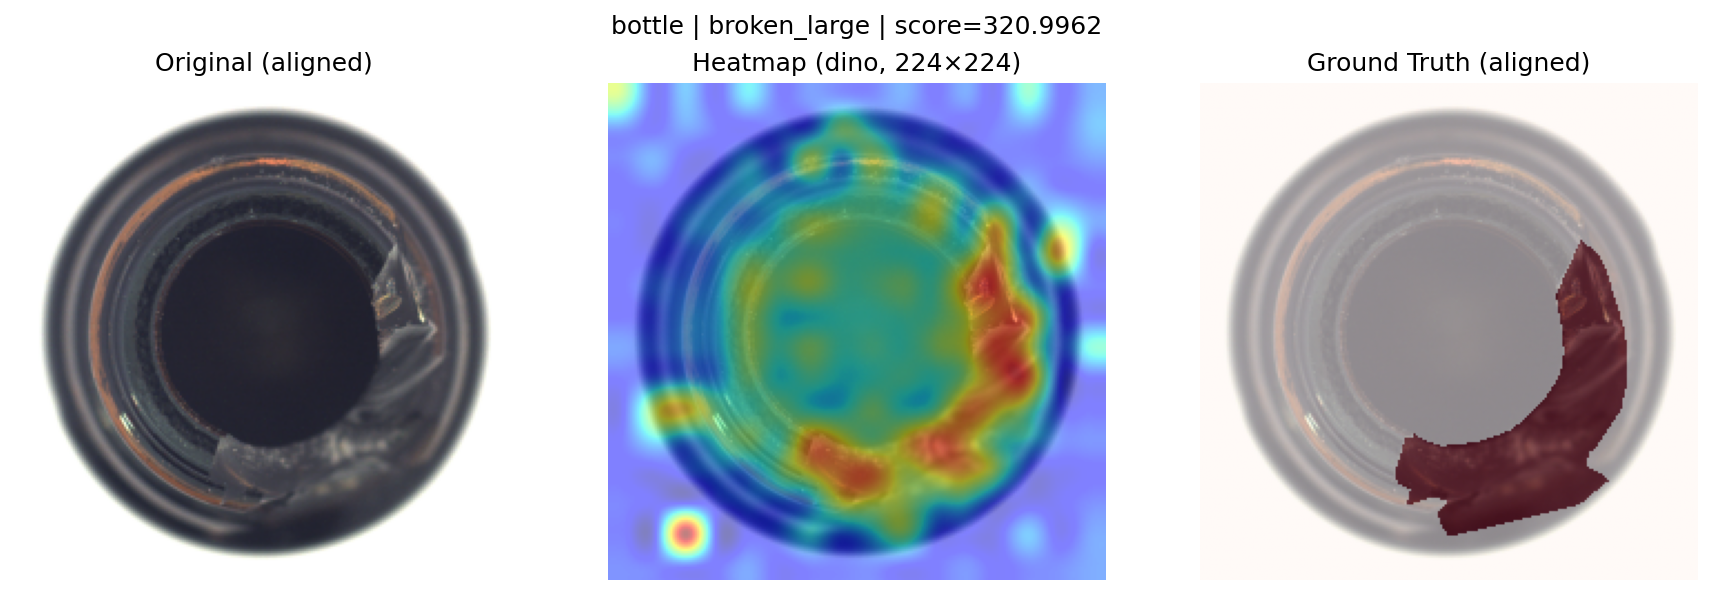

MAHALANOBIS · MAE → ..\triplets_mahalanobis\mae\bottle\broken_large__000.png


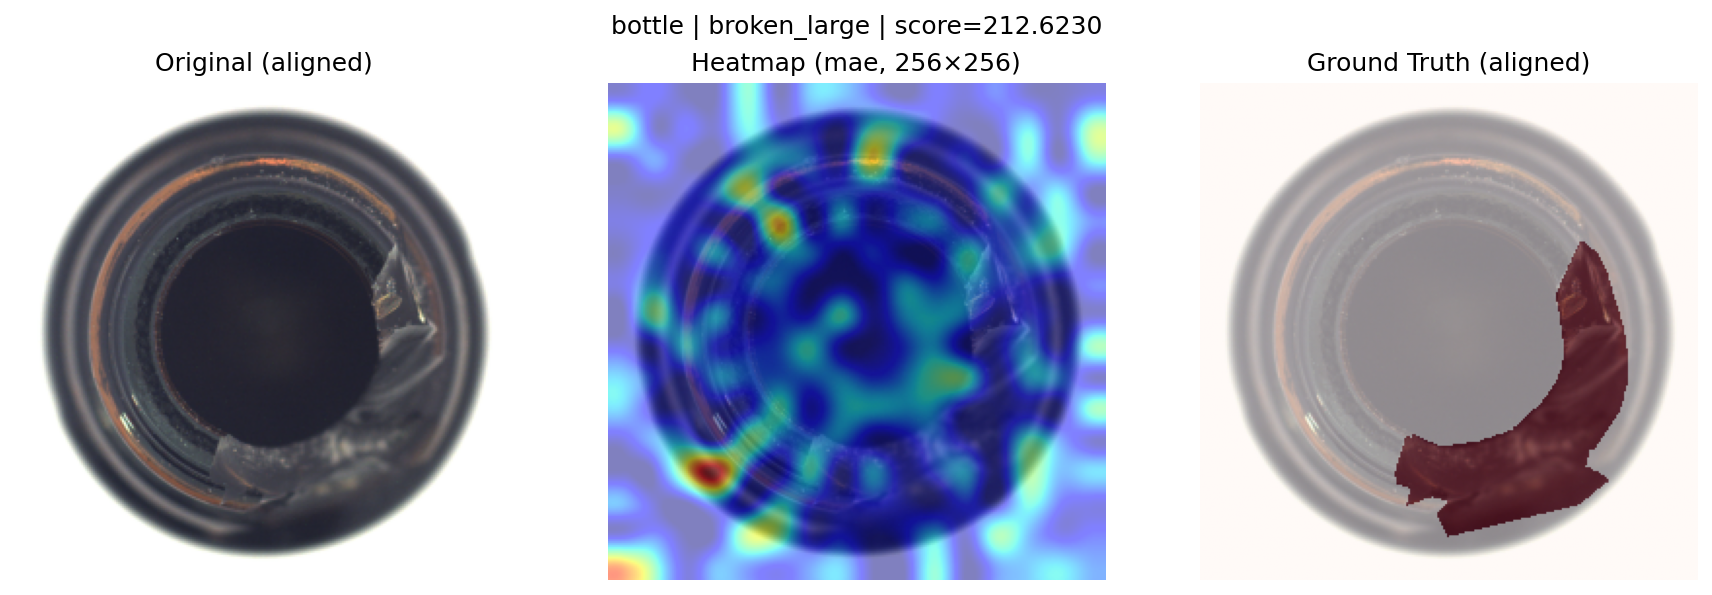

In [52]:
from pathlib import Path
from IPython.display import display, Image
import numpy as np
from PIL import Image as PILImage
import matplotlib.pyplot as plt
import cv2

# ---------------- Config: choose the sample you want ----------------
CATEGORY  = "bottle"
RAW_LABEL = "broken_large"
FILENAME  = "000.png"      # original filename
MVTEC_ROOT = Path("../data/mvtec")

BASE_SCORES = {
    "knn": Path("../scores_knn"),
    "mahalanobis": Path("../scores_mahalanobis"),
}

# Triplet output base dirs
BASE_TRIPLETS = {
    "knn": Path("../triplets_knn"),
    "mahalanobis": Path("../triplets_mahalanobis"),
}

# ---------------- Utilities ----------------
def _input_size_from_backbone(backbone: str) -> tuple[int, int]:
    b = str(backbone).lower()
    return (224, 224) if b == "dino" else (256, 256) if b == "mae" else (224, 224)

def _npz_path_for_sample(method: str, backbone: str, category: str, raw_label: str, filename: str) -> Path:
    """
    Find the npz file for a given sample in patch_scores:
    scores_<method>/patch_scores/<backbone>/<category>/test/<raw_label>/<filename>.npz
    """
    root = BASE_SCORES[method] / "patch_scores" / backbone / category / "test" / raw_label
    return root / f"{filename}.npz"

def _img_path_from_meta(meta: dict, mvtec_root: Path) -> Path:
    fname = Path(meta["path"]).name
    return (mvtec_root / meta["category"] / str(meta["split"]).lower() / meta["raw_label"] / fname).resolve()

def _mask_path_from_meta(meta: dict, mvtec_root: Path) -> Path:
    fname = Path(meta["path"]).name
    return (mvtec_root / meta["category"] / "ground_truth" / meta["raw_label"] / fname.replace(".png", "_mask.png")).resolve()

def _compute_global_minmax_for_category(cat_dir: Path) -> tuple[float, float]:
    """Global min/max over patch_scores in a category (for fair color scaling)."""
    npz_files = list(cat_dir.rglob("*.npz"))
    mins, maxs = [], []
    for f in npz_files:
        try:
            d = np.load(f, allow_pickle=True)
            ps = d["patch_scores"]
            mins.append(float(ps.min())); maxs.append(float(ps.max()))
        except Exception:
            pass
    if not mins:
        return (0.0, 1.0)
    gmin, gmax = float(min(mins)), float(max(maxs))
    if not np.isfinite(gmin) or not np.isfinite(gmax) or gmax <= gmin:
        return (0.0, 1.0)
    return gmin, gmax

def _make_heatmap_aligned(patch_scores: np.ndarray, grid_hw: tuple[int,int], H_in: int, W_in: int,
                          norm_min: float | None, norm_max: float | None) -> np.ndarray:
    gh, gw = grid_hw
    patch_map = patch_scores.reshape(gh, gw)
    heat = cv2.resize(patch_map, (W_in, H_in), interpolation=cv2.INTER_CUBIC).astype(np.float32)
    if norm_min is not None and norm_max is not None and norm_max > norm_min:
        heat = (heat - norm_min) / (norm_max - norm_min)
    else:
        mn, mx = float(heat.min()), float(heat.max())
        heat = (heat - mn) / (mx - mn + 1e-8) if mx > mn else np.zeros_like(heat, dtype=np.float32)
    np.clip(heat, 0.0, 1.0, out=heat)
    return heat

def _plot_triplet_to_file_from_npz(npz_path: Path, out_path: Path, mvtec_root: Path,
                                   backbone: str, norm_min: float | None, norm_max: float | None,
                                   alpha: float = 0.5, cmap: str = "jet"):
    d = np.load(npz_path, allow_pickle=True)
    patch_scores = d["patch_scores"]
    gh, gw = [int(x) for x in d["grid_hw"]]
    meta = d["meta"].item()
    img_score = float(d["image_score"])

    # load original + align to model input size
    H_in, W_in = _input_size_from_backbone(backbone)
    ipath = _img_path_from_meta(meta, mvtec_root)
    img = np.array(PILImage.open(ipath).convert("RGB"))
    img_aligned = cv2.resize(img, (W_in, H_in), interpolation=cv2.INTER_AREA)

    # heatmap (aligned) with global normalization
    heat = _make_heatmap_aligned(patch_scores, (gh, gw), H_in, W_in, norm_min, norm_max)

    # ground-truth mask
    mpath = _mask_path_from_meta(meta, mvtec_root)
    if mpath.exists():
        mask_raw = np.array(PILImage.open(mpath).convert("L"))
        mask = cv2.resize(mask_raw, (W_in, H_in), interpolation=cv2.INTER_NEAREST)
    else:
        mask = np.zeros((H_in, W_in), dtype=np.uint8)

    # figure
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img_aligned); axs[0].set_title("Original (aligned)"); axs[0].axis("off")
    axs[1].imshow(img_aligned); axs[1].imshow(heat, cmap=cmap, alpha=alpha)
    axs[1].set_title(f"Heatmap ({backbone}, {H_in}×{W_in})"); axs[1].axis("off")
    axs[2].imshow(img_aligned); axs[2].imshow(mask, cmap="Reds", alpha=0.5)
    axs[2].set_title("Ground Truth (aligned)"); axs[2].axis("off")
    plt.suptitle(f"{meta['category']} | {meta['raw_label']} | score={img_score:.4f}", y=0.98)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close(fig)

def ensure_triplet(method: str, backbone: str, category: str, raw_label: str, filename: str) -> Path:
    """
    Create the triplet image if missing and return its path.
    Uses category-global normalization for consistent colors.
    """
    # where the final triplet should live
    out_dir = BASE_TRIPLETS[method] / backbone / category
    out_path = out_dir / f"{raw_label}__{filename.replace('.png','')}.png"

    if out_path.exists():
        return out_path

    # find the npz for this exact sample
    npz_path = _npz_path_for_sample(method, backbone, category, raw_label, filename)
    if not npz_path.exists():
        raise FileNotFoundError(f"NPZ not found for {method}/{backbone}: {npz_path}")

    # category-global min/max for fair color scaling
    cat_dir = BASE_SCORES[method] / "patch_scores" / backbone / category
    gmin, gmax = _compute_global_minmax_for_category(cat_dir)

    _plot_triplet_to_file_from_npz(npz_path, out_path, MVTEC_ROOT, backbone, gmin, gmax)
    return out_path

# ---------------- Ensure & show: one fixed sample across all 4 combos ----------------
PAIRS = [
    ("knn", "dino"),
    ("knn", "mae"),
    ("mahalanobis", "dino"),
    ("mahalanobis", "mae"),
]

print(f"Sample: {CATEGORY}/{RAW_LABEL}/{FILENAME}\n")
triplet_paths = {}
for method, backbone in PAIRS:
    try:
        p = ensure_triplet(method, backbone, CATEGORY, RAW_LABEL, FILENAME)
        triplet_paths[f"{method.upper()} · {backbone.upper()}"] = p
    except Exception as e:
        print(f"[MISS] {method.upper()} · {backbone.upper()}: {e}")

# display in order
for title, path in triplet_paths.items():
    print(title, "→", path)
    display(Image(filename=path))


### Fixed Example Comparison (one image across all methods)

To make the results directly comparable, we now take **the same sample**  
(e.g. `bottle/test/broken_large/000.png`) and generate triplets for all four  
method/backbone combinations:

- **KNN + DINO**  
- **KNN + MAE**  
- **Mahalanobis + DINO**  
- **Mahalanobis + MAE**

Each triplet again shows (from left to right):  
1. **Original image** (aligned to model input size, 224×224 for DINO / 256×256 for MAE)  
2. **Predicted anomaly heatmap** (overlay)  
3. **Ground truth mask** (if available)

By aligning the input and using **category-global normalization** for the heatmaps,  
the color scales are directly comparable.  
This setup allows a **fair side-by-side comparison** of how each method interprets the  
exact same defective region.

---

### Observations

- **DINO (both KNN and Mahalanobis)**  
  The anomaly regions are clearly localized. The red areas in the heatmap overlap well  
  with the ground-truth mask, making DINO highly suitable for pixel-level localization.  
  Between KNN and Mahalanobis, the difference is subtle:  
  - KNN tends to highlight slightly more scattered areas (more patch-wise).  
  - Mahalanobis produces somewhat smoother maps, since it models a global distribution.  

- **MAE (both KNN and Mahalanobis)**  
  The heatmaps are far less informative: red patches appear almost randomly,  
  without a clear correspondence to the defective region.  
  This matches literature results: **MAE features are optimized for reconstruction**  
  and carry less discriminative power for anomaly localization.  
  Consequently, while MAE can separate *good vs. defect* at the image level,  
  it is much weaker for **where** the defect is.

**Conclusion:**  
DINO provides reliable and interpretable localization, while MAE does not yield  
usable heatmaps. The choice between KNN and Mahalanobis mainly affects the  
"smoothness" of the maps, but both perform comparably in practice.


In [54]:
import matplotlib.pyplot as plt

# --- Collect triplet images ---
images = []
titles = []
for title, path in triplet_paths.items():
    img = np.array(PILImage.open(path).convert("RGB"))
    images.append(img)
    titles.append(title)

# --- Create figure with subplots stacked vertically ---
fig, axs = plt.subplots(len(images), 1, figsize=(8, 4*len(images)))
if len(images) == 1:
    axs = [axs]  # ensure iterable

for ax, img, title in zip(axs, images, titles):
    ax.imshow(img)
    ax.set_title(title, fontsize=12)
    ax.axis("off")

plt.tight_layout()
out_file = Path("../triplets_fixed_example_vertical.png")
plt.savefig(out_file, dpi=150, bbox_inches="tight")
plt.close(fig)

print("Saved:", out_file.resolve())



Saved: C:\Users\Fredi\MVTec\triplets_fixed_example_vertical.png
